# Assignment 4 - Graph Neural Networks

In this assignment we will implement graph representation, graph classification, neighborhood sampling and graph attention components. This assignment is based on the Chapter 13 from the book [https://udlbook.github.io/udlbook/](https://udlbook.github.io/udlbook/) 

## Part 1 - Graph Representation (10 points)

This notebook investigates representing graphs with matrices as illustrated in figure 13.4 from the book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
from itertools import permutations

In [2]:
# Routine to draw graph structure
def draw_graph_structure(adjacency_matrix):

  G = nx.Graph()
  n_node = adjacency_matrix.shape[0]
  for i in range(n_node):
    for j in range(i):
      if adjacency_matrix[i,j]:
          G.add_edge(i,j)

  nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True)
  plt.show()

[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


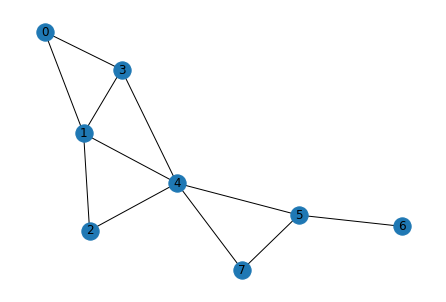

In [3]:
# Define a graph
# Note that the nodes are labelled from 0 rather than 1 as in the book
A = np.array([[0,1,0,1,0,0,0,0],
     [1,0,1,1,1,0,0,0],
     [0,1,0,0,1,0,0,0],
     [1,1,0,0,1,0,0,0],
     [0,1,1,1,0,1,0,1],
     [0,0,0,0,1,0,1,1],
     [0,0,0,0,0,1,0,0],
     [0,0,0,0,1,1,0,0]]);
print(A)
draw_graph_structure(A)

In [4]:
# 5 points
# TODO -- find algorithmically how many walks of length three are between nodes 3 and 7
A3 = np.linalg.matrix_power(A, 3)
walks_of_length_3_to_7 = A3[3, 7]
print("Number of  walks between nodes three and seven =", walks_of_length_3_to_7)

# 5 points
# TODO: Find algorithmically how many paths of length 3 are there between node 0 and every other node
x = np.zeros(A.shape[0], dtype=int)
num_nodes = A.shape[0]
routes = permutations(range(num_nodes), 4)
routes_start = [r for r in routes if r[0] == 0 and r[3] != 0]
for r in routes_start:
    if A[r[0], r[1]] and A[r[1], r[2]] and A[r[2], r[3]]:
        x[r[3]] += 1
#print("Number of paths of length 3 from node 0 to every other node \n", np.zeros_like(x).reshape(1,-1))
print("Number of paths of length 3 from node 0 to every other node: \n",x)

Number of  walks between nodes three and seven = 2
Number of paths of length 3 from node 0 to every other node: 
 [0 1 3 1 3 2 0 2]


## Part 2 - Graph Classification - 20 points

Let's build the components of a model that maps a chemical structure to a binary decision. This model might be used to predict whether a chemical is liquid at room temperature or not. We'll start by drawing the chemical structure.

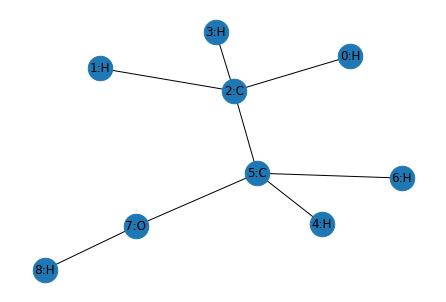

In [5]:
# Define a graph that represents the chemical structure of ethanol and draw it
# Each node is labelled with the node number and the element (carbon, hydrogen, oxygen)
G = nx.Graph()
G.add_edge('0:H','2:C')
G.add_edge('1:H','2:C')
G.add_edge('3:H','2:C')
G.add_edge('2:C','5:C')
G.add_edge('4:H','5:C')
G.add_edge('6:H','5:C')
G.add_edge('7:O','5:C')
G.add_edge('8:H','7:O')
nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True, node_size=600)
plt.show()

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[1. 1. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


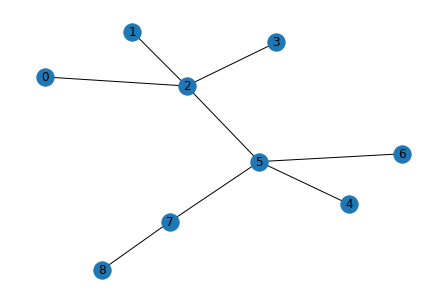

In [6]:
# 5 points
# Define adjacency matrix
# TODO -- Define the adjacency matrix for this chemical

def create_adjacency_matix(shape):
    adjacency_matrix = np.zeros(shape)
    sorted_nodes = sorted(G.nodes)
    node_index = {node: idx for idx, node in enumerate(sorted_nodes)}
    for node1, node2 in G.edges():
        # Get the indices for the nodes
        idx1 = node_index[node1]
        idx2 = node_index[node2]
        
        # Mark the corresponding matrix positions as 1
        adjacency_matrix[idx1][idx2] = 1
        adjacency_matrix[idx2][idx1] = 1  # For undirected graph
    
    return adjacency_matrix

A = create_adjacency_matix((9,9)) 

print(A)

# TODO -- Define node matrix
# There will be 9 nodes and 118 possible chemical elements
# so we'll define a 118x9 matrix.  Each column represents one
# node and is a one-hot vector (i.e. all zeros, except a single one at the
# chemical number of the element).
# Chemical numbers:  Hydrogen-->1, Carbon-->6,  Oxygen-->8
# Since the indices start at 0, we'll set element 0 to 1 for hydrogen, element 5
# to one for carbon, and element 7 to one for oxygen
# Replace this line:
X = np.zeros((118,9))
#For H
X[0, [0, 1, 3, 4, 6, 8]] = 1  
#For C
X[5, [2, 5]] = 1              
X[7, [7]] = 1  
# Print the top 15 rows of the data matrix
print(X[0:15,:])
draw_graph_structure(A)

Now let's define a network with four layers that maps this graph to a binary value, using the formulation in equation 13.11.

In [7]:
# We'll need these helper functions

# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

# Define the logistic sigmoid function
def sigmoid(x):
  return 1.0/(1.0+np.exp(-x))

In [8]:
# Our network will have K=3 hidden layers, and will use a dimension of D=200.
K = 3; D = 200
# Set seed so we always get the same random numbers
np.random.seed(1)
# Let's initialize the parameter matrices randomly with He initialization
Omega0 = np.random.normal(size=(D, 118)) * 2.0 / D
beta0 = np.random.normal(size=(D,1)) * 2.0 / D
Omega1 = np.random.normal(size=(D, D)) * 2.0 / D
beta1 = np.random.normal(size=(D,1)) * 2.0 / D
Omega2 = np.random.normal(size=(D, D)) * 2.0 / D
beta2 = np.random.normal(size=(D,1)) * 2.0 / D
omega3 = np.random.normal(size=(1, D))
beta3 = np.random.normal(size=(1,1))

In [9]:
def graph_neural_network(A, X, Omega0, beta0, Omega1, beta1, Omega2, beta2, omega3, beta3):
  # TODO Define this network according to equation 13.11 from the book
  # We will use ReLU as the nonlinear activation for the hidden layers
  # We will use sigmoid activation for the last layer
  
  identity_matrix = np.identity(A.shape[0])
  adjacency_self = A + identity_matrix  
  ones_row_vector = np.ones((X.shape[1], 1)) 
  H1 = ReLU(np.dot(beta0, ones_row_vector.T) + np.dot(np.dot(Omega0, X), adjacency_self))
  H2 = ReLU(np.dot(beta1, ones_row_vector.T) + np.dot(np.dot(Omega1, H1), adjacency_self))
  H3 = ReLU(np.dot(beta2, ones_row_vector.T) + np.dot(np.dot(Omega2, H2), adjacency_self))
  H4 = sigmoid(beta3 + omega3 @ H3 / A.shape[0])
  f  = H4
  return f

In [ ]:
# 10 points
# Let's test this network
f = graph_neural_network(A,X, Omega0, beta0, Omega1, beta1, Omega2, beta2, omega3, beta3)
print("Your value is %3f: "%(f[0,0]))

Your value is 0.304334: 


In [11]:
# 5 points
# Let's check that permuting the indices of the graph doesn't change
# the output of the network
# Define a permutation matrix
P = np.array([[0,1,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,1,0,0]]);

# TODO -- Use this matrix to permute the adjacency matrix A and node matrix X
# Replace these lines

A_permuted = np.dot(np.dot(P.T, A), P)  
X_permuted = np.dot(X, P)  

f2 = graph_neural_network(A_permuted,X_permuted, Omega0, beta0, Omega1, beta1, Omega2, beta2, omega3, beta3)
print("After permutation value is %3f: "%(f2[0,0]), "Before permutation value is %3f: "%(f[0,0]))

After permutation value is 0.304384:  Before permutation value is 0.304334: 


## Part 3 - Neighborhood Sampling - 40 points
In this section we will investigate neighborhood sampling of graphs as in figure 13.10 from the book.

Let's construct the graph from figure 13.10, which has 23 nodes.

In [2]:
# Define adjacency matrix
# DO NOT change this matrix
A = np.array([[0,1,1,1,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [1,0,1,0,0, 0,0,0,1,1, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [1,1,0,1,0, 0,0,0,0,1, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [1,0,1,0,1, 0,1,1,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [0,0,0,1,0, 1,0,1,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [0,0,0,0,1, 0,0,1,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [0,0,0,1,0, 0,0,1,0,1, 1,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [0,0,0,1,1, 1,1,0,0,0, 1,0,0,1,0, 0,0,0,0,0, 0,0,0],
              [0,1,0,0,0, 0,0,0,0,1, 0,0,0,0,0, 0,0,0,0,0, 0,0,0],
              [0,1,1,0,0, 0,1,0,1,0, 0,1,1,0,0, 0,1,0,0,0, 0,0,0],
              [0,0,0,0,0, 0,1,1,0,0, 0,0,1,0,0, 0,0,0,0,0, 0,0,0],
              [0,0,0,0,0, 0,0,0,0,1, 0,0,0,0,1, 1,1,0,0,0, 0,0,0],
              [0,0,0,0,0, 0,0,0,0,1, 1,0,0,1,0, 0,1,1,0,0, 0,0,0],
              [0,0,0,0,0, 0,0,1,0,0, 0,0,1,0,0, 0,0,1,1,0, 0,0,0],
              [0,0,0,0,0, 0,0,0,0,0, 0,1,0,0,0, 1,0,0,0,1, 0,0,0],
              [0,0,0,0,0, 0,0,0,0,0, 0,1,0,0,1, 0,1,0,0,1, 0,0,0],
              [0,0,0,0,0, 0,0,0,0,1, 0,1,1,0,0, 1,0,1,0,1, 0,0,0],
              [0,0,0,0,0, 0,0,0,0,0, 0,0,1,1,0, 0,1,0,1,0, 1,1,1],
              [0,0,0,0,0, 0,0,0,0,0, 0,0,0,1,0, 0,0,1,0,0, 0,0,1],
              [0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,1, 1,1,0,0,0, 1,0,0],
              [0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,1,0,1, 0,1,0],
              [0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,1,0,0, 1,0,1],
              [0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,1,1,0, 0,1,0]]);
print(A)

[[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 

In [3]:
# Routine to draw graph structure, highlighting original node (brown in fig 13.10)
# and neighborhood nodes (orange in figure 13.10)
def draw_graph_structure(adjacency_matrix, original_node, neighborhood_nodes=None):

  G = nx.Graph()
  n_node = adjacency_matrix.shape[0]
  for i in range(n_node):
    for j in range(i):
      if adjacency_matrix[i,j]:
          G.add_edge(i,j)

  color_map = []

  for node in G:
    if original_node[node]:
      color_map.append('brown')
    else:
      if neighborhood_nodes[node]:
        color_map.append('orange')
      else:
        color_map.append('white')

  nx.draw(G, nx.spring_layout(G, seed = 7), with_labels=True,node_color=color_map)
  plt.show()

Output layer:


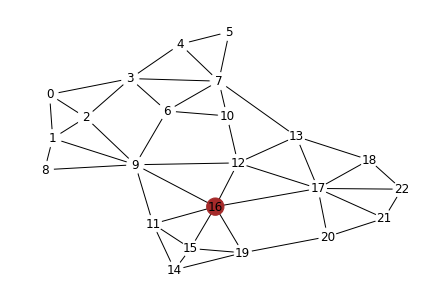

In [ ]:
n_nodes = A.shape[0]
# Define a single output layer node
output_layer_nodes=np.zeros((n_nodes,1)); output_layer_nodes[16]=1
# Define the neighboring nodes 
neighbor_nodes = np.zeros((n_nodes,1))
print("Output layer:")
draw_graph_structure(A, output_layer_nodes, neighbor_nodes)

Let's imagine that we want to form a batch for a node labelling task that consists of just node 16 in the output layer (highlighted). The network consists of the input, hidden layer 1, hidden layer2, and the output layer.

Hidden layer 2:


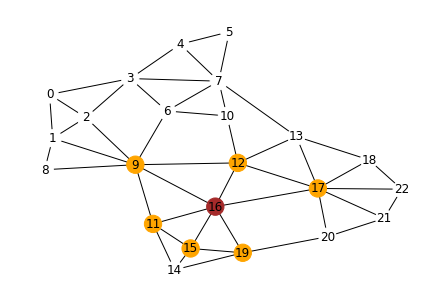

In [ ]:
# 4 points
# TODO Find the nodes in hidden layer 2 that connect to node 16 in the output layer
# using the adjacency matrix
hidden_layer2_nodes = np.zeros((n_nodes,1));
hidden_layer2_nodes[np.where(A[16, :] == 1)] = 1
print("Hidden layer 2:")
draw_graph_structure(A, output_layer_nodes, hidden_layer2_nodes)

Hidden layer 1:


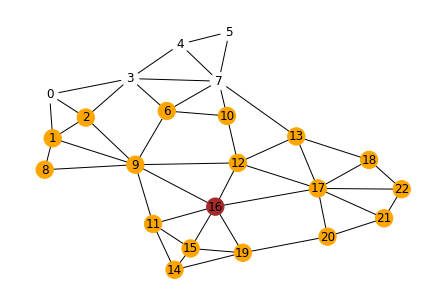

In [8]:
# 3 points
# TODO - Find the nodes in hidden layer 1 that connect that connect to node 16 in the output layer
# using the adjacency matrix

hidden_layer1_nodes = np.zeros((n_nodes,1))

# Get neighbors of node 16 
neighbor_indices_16 = np.argwhere(A[16] == 1).flatten()
# Get neighbors of neighbors
connections = []
for neighbor in neighbor_indices_16:
    neighbors_of_neighbors = np.argwhere(A[neighbor] == 1).flatten()
    connections.append(neighbors_of_neighbors)

# Combine
all_connection_nodes = np.concatenate([neighbor_indices_16] + connections)
all_connection_nodes = np.unique(all_connection_nodes)
hidden_layer1_nodes[all_connection_nodes] = 1

print("Hidden layer 1:")
draw_graph_structure(A, output_layer_nodes, hidden_layer1_nodes)

Input layer:


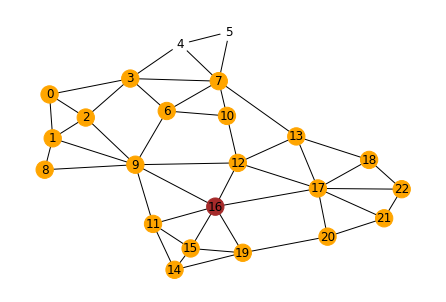

In [9]:
# 3 points
# TODO Find the nodes in the input layer that connect to node 16 in the output layer
# using the adjacency matrix

input_layer_nodes = np.zeros((n_nodes,1))
neighbor_index_16 = np.where(A[16] == 1)[0] 
neighbors_of_neoghbors_indices = np.where(A[all_connection_nodes] == 1)   
node_indices = neighbors_of_neoghbors_indices[1] 
unique_node = np.unique(node_indices)
input_layer_nodes[unique_node] = 1

print("Input layer:")
draw_graph_structure(A, output_layer_nodes, input_layer_nodes)


This is bad news. This is a fairly sparsely connected graph (i.e. adjacency matrix is mostly zeros) and there are only two hidden layers. Nonetheless, we have to involve almost all the nodes in the graph to compute the loss at this output.

To resolve this problem, we'll use neighborhood sampling. We'll start again with a single node in the output layer.

Output layer:


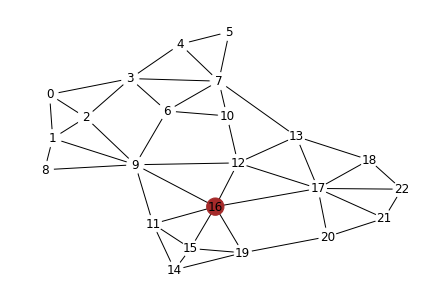

In [10]:
print("Output layer:")
draw_graph_structure(A, output_layer_nodes, neighbor_nodes)

In [11]:
# Define number of neighbors to sample
n_sample = 3

Hidden layer 2 (sampled):


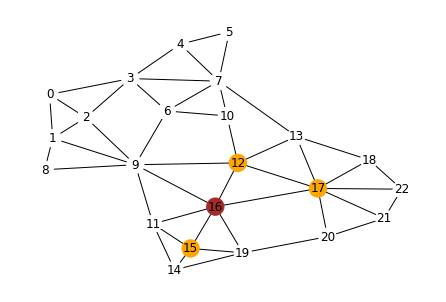

In [ ]:
# 10 points
# TODO Find the nodes in hidden layer 2 that connect to node 16 in the output layer
# using the adjacency matrix.  Then sample n_sample of these nodes randomly without
# replacement.

hidden_layer2_nodes = np.zeros((n_nodes, 1))
neighbors_16 = np.where(A[16] == 1)[0]
# Sample randomly without replacement
sampled_randomly = np.random.choice(neighbors_16, size=n_sample, replace=False)
hidden_layer2_nodes[sampled_randomly] = 1

print("Hidden layer 2 (sampled):")
draw_graph_structure(A, output_layer_nodes, hidden_layer2_nodes)


Hidden layer 1:


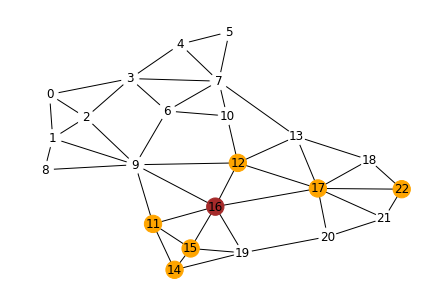

In [ ]:
# 10 points
# TODO Find the nodes in hidden layer 1 that connect to the nodes in hidden layer 2
# using the adjacency matrix.  Then sample n_sample of these nodes randomly without
# replacement.  Make sure not to sample nodes that were already included in hidden layer 2, or the output layer.
# The nodes at hidden layer 1 are the union of these nodes and the nodes in hidden layer 2

# Initialize hidden layer 1 
hidden_layer1_nodes = np.zeros((n_nodes, 1))

# Find nodes in hidden layer 2 
hidden_layer2 = np.where(hidden_layer2_nodes == 1)[0]

# Find neighbors of nodes in hidden layer 2 (i.e., nodes connected to hidden layer 2)
neighbors_hidden1 = []
for n in hidden_layer2:
    neighbors = np.where(A[n] == 1)[0]
    neighbors_hidden1.extend(neighbors)

# Exclude nodes already exists
excluded_nodes = set(hidden_layer2).union(set(np.where(output_layer_nodes == 1)[0]))

# Remove duplicates and overlap 
neighbors_hidden1 = list(set(neighbors_hidden1) - excluded_nodes)

# Randomly sample 
sampled_hidden1 = np.random.choice(neighbors_hidden1, min(len(neighbors_hidden1), n_sample), replace=False)

# Union 
hidden_layer1_indices_union = list(set(sampled_hidden1).union(set(hidden_layer2)))

# Update 
hidden_layer1_nodes[hidden_layer1_indices_union] = 1

# Draw graph structure
print("Hidden layer 1:")
draw_graph_structure(A, output_layer_nodes, hidden_layer1_nodes)


Input layer:


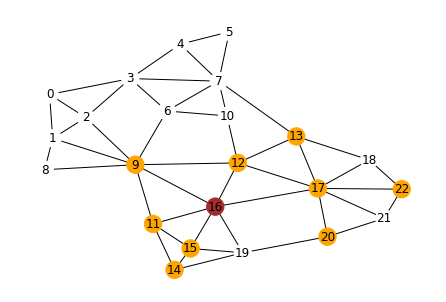

In [ ]:
# 10 points
# TODO Find the nodes in the input layer that connect to the nodes in hidden layer 1
# using the adjacency matrix.  Then sample n_sample of these nodes randomly without
# replacement.  Make sure not to sample nodes that were already included in hidden layer 1,2, or the output layer.
# The nodes at the input layer are the union of these nodes and the nodes in hidden layers 1 and 2


# Initialize input layer node tracker
input_layer_nodes = np.zeros((n_nodes, 1))

# Find nodes in hidden layer 1
hidden_layer1_nodes = np.where(hidden_layer1_nodes == 1)[0]

# Find neighbors of nodes in hidden layer 1 (i.e., nodes connected to hidden layer 1)
neighbors_input = []
for node in hidden_layer1_nodes:
    neighbors = np.where(A[node] == 1)[0]
    neighbors_input.extend(neighbors)

# Exclude nodes already in hidden layers 1, 2, or the output layer
excluded_nodes = set(hidden_layer1_nodes).union(set(hidden_layer2)).union(set(np.where(output_layer_nodes == 1)[0]))

# Remove duplicates and overlap with excluded nodes
neighbors_input = list(set(neighbors_input) - excluded_nodes)

# Random sampling
n_sample_input = min(len(neighbors_input), n_sample)
sampled_input = np.random.choice(neighbors_input, n_sample_input, replace=False)

# Union 
input_layer_indices_union = list(set(sampled_input).union(hidden_layer1_nodes).union(hidden_layer2))

# Update 
input_layer_nodes[input_layer_indices_union] = 1

print("Input layer:")
draw_graph_structure(A, output_layer_nodes, input_layer_nodes)

If you did this correctly, there should be 9 yellow nodes in the figure. The "receptive field" of node 16 in the output layer increases much more slowly as we move back through the layers of the network.

## Part 4 - Graph Attention Network - 30 points

In this part we will build a graph attention mechanism from scratch, as discussed in section 13.8.6 of the book and illustrated in figure 13.12c

The self-attention mechanism maps $N$ inputs $\mathbf{x}_{n}\in\mathbb{R}^{D}$ and returns $N$ outputs $\mathbf{x}'_{n}\in \mathbb{R}^{D}$.  

In [34]:
# Set seed so we get the same random numbers
np.random.seed(1)
# Number of nodes in the graph
N = 8
# Number of dimensions of each input
D = 4

# Define a graph
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]]);
print(A)

# Let's also define some random data
X = np.random.normal(size=(D,N))

[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


We need parameters for the graph attention layer. See Equation 13.22 - 13.24

In [35]:
# Choose random values for the parameters
omega = np.random.normal(size=(D,D))
beta = np.random.normal(size=(D,1))
phi = np.random.normal(size=(2*D,1))

We'll need a softmax operation that operates on the columns of the matrix and a ReLU function as well

In [36]:
# Define softmax operation that works independently on each column
def softmax_cols(data_in):
  # Exponentiate all of the values
  exp_values = np.exp(data_in) ;
  # Sum over columns
  denom = np.sum(exp_values, axis = 0);
  # Replicate denominator to N rows
  denom = np.matmul(np.ones((data_in.shape[0],1)), denom[np.newaxis,:])
  # Compute softmax
  softmax = exp_values / denom
  # return the answer
  return softmax


# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

In [ ]:
# 30 points 
# Now let's compute self attention in matrix form
# def graph_attention(X,omega, beta, phi, A):

#   # TODO -- Write this function (see figure 13.12c)
#   # 1. Compute X_prime
#   # 2. Compute S
#   # 3. To apply the mask, set S to a very large negative number (e.g. -1e20) everywhere where A+I is zero
#   # 4. Run the softmax function to compute the attention values
#   # 5. Postmultiply X' by the attention values
#   # 6. Apply the ReLU function
#   # Replace this line:
#   #output = np.ones_like(X) ;

def graph_attention(X, omega, beta, phi, A):
    #Compute X_prime
    vector = np.ones((X.shape[1], 1))  
    X_prime = omega @ X + beta @ vector.T  

    #Compute S 
    S = np.zeros((N, N))  
    for i in range(N):
        for j in range(N):
            combined = np.concatenate((X_prime[:, i], X_prime[:, j])).reshape(-1, 1)
            attention_score = np.dot(phi.T, combined)  
            S[i, j] = attention_score
  
    #Apply ReLU 
    S = ReLU(S)  

    #Apply the mask
    identity_matrix = np.identity(A.shape[0])  
    mask = (A + identity_matrix == 0)  
    S[mask] = np.finfo(S.dtype).min 

    #Softmax
    attention_values = softmax_cols(S)  

    #Postmultiply X' by the attention values
    X_postmultiply = X_prime @ attention_values  

    #Apply ReLU 
    output = ReLU(X_postmultiply)  

    return output

  

In [42]:
# Test out the graph attention mechanism
np.set_printoptions(precision=3)
output = graph_attention(X, omega, beta, phi, A);
print("Correct answer is:")
print("[[0.    0.028 0.37  0.    0.97  0.    0.    0.698]")
print(" [0.    0.    0.    0.    1.184 0.    2.654 0.  ]")
print(" [1.13  0.564 0.    1.298 0.268 0.    0.    0.779]")
print(" [0.825 0.    0.    1.175 0.    0.    0.    0.  ]]]")


print("Your answer is:")
print(output)

Correct answer is:
[[0.    0.028 0.37  0.    0.97  0.    0.    0.698]
 [0.    0.    0.    0.    1.184 0.    2.654 0.  ]
 [1.13  0.564 0.    1.298 0.268 0.    0.    0.779]
 [0.825 0.    0.    1.175 0.    0.    0.    0.  ]]]
Your answer is:
[[0.    0.028 0.37  0.    0.97  0.    0.    0.698]
 [0.    0.    0.    0.    1.184 0.    2.654 0.   ]
 [1.13  0.564 0.    1.298 0.268 0.    0.    0.779]
 [0.825 0.    0.    1.175 0.    0.    0.    0.   ]]


/tmp/ipykernel_2177525/202981505.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[i, j] = attention_score
